# Time dependence and PT-TEMPO
Guide to using the OQuPy package to compute the dynamics of a many-body system of the type introduced in [FowlerWright2021] ([arXiv:2112.09003](http://arxiv.org/abs/2112.09003)). We demonstrate both the TEMPO and PT-TEMPO methods for this calculation.

**Contents:**

* Example - Dicke Hamiltonian under the rotating wave approximation
    1. Many-body system and environment Hamiltonian
    2. System Hamiltonian and field equation of motion after the mean-field reduction
    3. Create time dependent system with field object
    4. TEMPO computation for single dynamics
    5. PT-TEMPO computation for multiple sets of dynamics

First, import OQuPy and other relevant packages:

In [2]:
import sys
sys.path.insert(0,'..')

import oqupy
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensornetwork'

Check the installed OQuPy version; TEMPO with mean-field evolution was introduced in **?.?.0**

In [2]:
oqupy.__version__

'0.2-dev'

The following matrices will be useful below:

In [3]:
sigma_z = oqupy.operators.sigma("z")
sigma_plus = oqupy.operators.sigma("+")
sigma_minus = oqupy.operators.sigma("-")

NameError: name 'oqupy' is not defined

-------------------------------------------------
## Example - Dicke Hamiltonian under the rotating wave approximation

Our goal will be to reproduce **Fig. 2a.** of [FowlerWright2021] ([arXiv:2112.09003](http://arxiv.org/abs/2112.09003)), firstly using TEMPO to obtain a single line from this figure, and then PT-TEMPO to obtain all lines in short succession. 

### 1. Many-body system and environment Hamiltonian
The Hamiltonian describing the many-body system with one-to-all light-matter coupling is
$$
H_{S} = \omega_c a^{\dagger}_{}a^{\vphantom{\dagger}}_{} 
	+ \sum_{i=1}^N \left[\frac{\omega_0}{2} \sigma^z_i
	+  \frac{\Omega}{2\sqrt{N}} \left( a^{\vphantom{\dagger}}_{} \sigma^+_i + a^{\dagger}_{} \sigma^-_i \right)\right]
$$
Together with the vibrational environment of each molecule,
$$
	H_{E}^{(i)} = \sum_{j} \left[	\nu_{j} b^{\dagger}_{j} b^{\vphantom{\dagger}}_{j} 
	+ \frac{\xi_{j}}{2} (b^{\vphantom{\dagger}}_{j}+b^{\dagger}_{j})\sigma^z_i\right]\text{,}
$$
which is taken to be a continuum of low frequency modes with coupling characterized by a spectral density 
$$
\begin{align*}
J(\nu) &= \sum_{j}  \left(\frac{\xi_j}{2}\right)^2
\delta(\nu-\nu_j) \\
&= 2\alpha \nu e^{-(\nu/\nu_c)^2}\text{,} \quad \nu>0\text{,}
\end{align*}
$$
where $\alpha=0.25$ and $\nu_c=0.15$ eV for the environment of BODIPY-Br considered in the Letter. Other system and environment parameters relevant to **Fig. 2a.** are, in units of eV,
* $T=0.026$ ($300$ K) - environment temperature
* $\omega_0=0$ - two-level system frequency**\***
* $\omega_c=-0.02$ - bare cavity frequency
* $\Omega=0.2$ - collective light-matter coupling

together with the rates
* $\kappa=0.01$ - field decay
* $\Gamma_\downarrow = 0.01$ - electronic dissipation
* $\Gamma_\uparrow \in (0.2\Gamma_\downarrow,0.8\Gamma_\downarrow) $ - electronic pumping

which appear as prefactors for Markovian terms in the quantum master equation for the total density operator
$$
		\partial_t \rho = -i \biggl[ H_S + \sum_{i=1}^N H_E^{(i)}, \rho \biggr]
	+ 2 \kappa \mathcal{L}[a^{\vphantom{\dagger}}_{}]
	+ \sum_{i=1}^N (\Gamma_\uparrow \mathcal{L}[\sigma^+_i]
	+  \Gamma_\downarrow \mathcal{L}[\sigma^-_i])\text{.}
$$
As indicated, it is the pump strength $\Gamma_\uparrow$ that will be varied to generate the different lines of **Fig. 2a.** All other parameters are defined in the following code box.


**\***N.B. for calculating the dynamics only the detuning $\omega_c-\omega_0$ is relevant, so we set $\omega_0=0$ for conveninence.

In [1]:
alpha = 0.25
nu_c = 0.15
T = 0.026
omega_0 = 0
omega_c = -0.02
Omega = 0.2

kappa = 0.01
Gamma_down = 0.01

### 2. System Hamiltonian and field equation of motion after the mean-field reduction

The mean-field approach is based on the product-state ansatz
$$
\rho = \rho_a \otimes \bigotimes_{i=1}^N \rho_i
$$ 
where $\rho_a= \text{Tr}_{\otimes{i}}\rho$ is obtained from the partial trace taken over the Hilbert space of all two-level systems and $ \rho_i = \text{Tr}_{a, \otimes{j\neq i}} \rho$ from the partial trace over all but the photonic degree of freedom. As detailed in the Supplemental Material of the Letter, after rescaling the field $\langle a \rangle \to \langle a \rangle/\sqrt{N}$ ($\langle a \rangle$ scales with $\sqrt{N}$ in the lasing phase), the dynamics are controlled by the mean-field Hamiltonian $H_{\text{MF}}$ for a *single molecule,*
$$
	H_\text{MF} = 
 \frac{\omega_0}{2}\sigma^z+
	\frac{\Omega}{2}\left( \langle a \rangle \sigma^+ +
	\langle a \rangle^{*}\sigma^- \right)\text{,}
$$
together with the equation of motion for the field $\langle a \rangle$,
$$
\partial_t \langle a \rangle = 
	- (i\omega_c+\kappa)\langle a \rangle- i \frac{\Omega}{2}\langle\sigma^-\rangle.
$$
To encode this information, and hence compute the dynamics, we use a `TimedependentSystemWithField` object. In the following we use $\rho$ (no subscript) to denote the density operator of a a single two-level system (rather than the total many-body operator), since this forms the system in our TEMPO simulations.

### 3. Create time dependent system with field object
The `TimedependentSystemWithField` object requires two physical inputs: a Hamiltonian, which is a function of time $t$ and field value $\langle a \rangle$ (in that order), and a equation of motion for the field, which is a function of time $t$, two-level system state $\rho$ and field value $\langle a \rangle$. Note here $\rho$ is provided as a $2\times2$ matrix, hence to compute the expectation $\langle \sigma^- \rangle$ we must multiple $\rho$ by $\sigma^-$ and take the trace:

In [7]:
def H_MF(t, a):
    return 0.5 * omega_0 * sigmaz +\
        0.5 * Omega * (a * sigma_plus + np.conj(a) * sigma_minus)
def field_eom(t, state, a):
    expec_val = np.matmul(sigma_minus, state).trace().real
    return -(1j * omega_c + kappa) * a - 0.5j * Omega * expect_val
    

system = oqupy.TimeDependentSystem(hamiltonian_t)


In addition, we need to specify Lindland operators for the pumping and dissipation processes. For now we will use a pumping $\Gamma_\uparrow = 0.8 \Gamma_\downarrow$, but in the PT-TEMPO computation below this will be varied.

In [ ]:
Gamma_up = 0.8 * Gamma_down
gammas = [ lambda t: Gamma_down, lambda t: Gamma_up]
lindblads = [ lambda t: sigma_minus, lambda t: sigma_plus]

Note the rates and linblad operators must be callables taking a single argument---time---even though in our example there is no time-dependence (there is no `SystemWithField` class). Including the above, the system is then constructed with

In [ ]:
system = oqupy.TimeDependentSystemWithField(
        H_MF,
        field_eom,
        gammas=gammas,
        lindblad_operators=lindblads)

Correlations and a Bath object are created in the same way as in any other TEMPO computation (see preeceding tutorials):

In [ ]:
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(0.5 * sigma_z, correlations)

### 4. TEMPO computation

For our simulations we use the same initial conditions for the system and state used in the Letter:

In [ ]:
initial_field = np.sqrt(0.05) # Note n_0 = <a^dagger a>(0) = 0.05
initial_state = np.array([[0,0],[0,1]]) # spin down

as well as the computational parameters:

In [8]:
tempo_parameters = oqupy.TempoParameters(dt=0.6, dkmax=250, epsrel=10**(-4))
start_time = 0.0
end_time = 1000.0

100.0%   50 of   50 [########################################] 00:00:01
Elapsed time: 1.4s


where for the sake of reducing the computation time the precision was lowered and the simulation time halved relative to the Letter. The only sutblty here is that the units of time are those with $\hbar=1$; you can check $t=1000$ corresponds to $t=4$ ps in SI units.
`oqupy.TempoWithField` and the `.compute` method may then be used to compute the dynamics in exactly the same way a call to `oqupy.Tempo` is used to compute the dynamics for an ordinary `System` or `TimeDependentSystem`:

In [ ]:
tempo_sys = oqupy.Tempo(system=system,
                        bath=bath,
                        initial_state=initial_state,
                        start_time=start_time,
                        parameters=tempo_parameters)
dynamics_with_field = tempo_sys.compute(end_time=end_time)

Note `dynamics_with_field` contains both the timesteps and state matrices at each timestel, plus the corresponding field values. We plot the latter below which describes (part of) a single curve from **Fig. 2.**

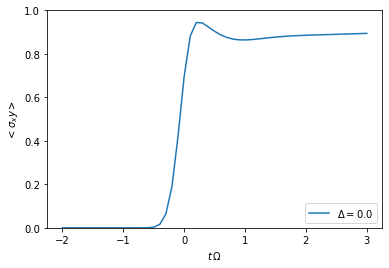

In [9]:
t, s_x = dynamics.expectations(sigma_x, real=True)
t, s_y = dynamics.expectations(sigma_y, real=True)
s_xy = np.sqrt(s_x**2 + s_y**2)
plt.plot(t, s_xy, label=r'$\Delta = 0.0$')
plt.xlabel(r'$t\,\Omega$')
plt.ylabel(r'$<\sigma_xy>$')
plt.ylim((0.0,1.0))
plt.legend(loc=4)

### 5. Using PT-TEMPO to explore many different laser pulses
If we want to do the same computation for a set of different laser pulses (and thus different time dependent system Hamiltonians), we could repeate the above procedure. However, for a large number of different system Hamiltonians this is impractical. In such cases one may instead use the process tensor approach (PT-TEMPO) wherein the bath influence tensors are computed separately from the rest of the network. This produces an object known as the process tensor which may then be used with many different system Hamiltonians at relatively little cost.

In [10]:
tempo_parameters = oqupy.TempoParameters(dt=0.1, dkmax=20, epsrel=10**(-4))

process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                        start_time=-2.0,
                                        end_time=3.0,
                                        parameters=tempo_parameters)

100.0%   50 of   50 [########################################] 00:00:01
Elapsed time: 1.3s


Given we want to calculate $\langle\sigma_{xy}\rangle(t)$ for 5 different laser pulse detunings, we define a seperate system object for each laser pulse:

In [11]:
deltas = [-10.0, -5.0, 0.0, 5.0, 10.0]
systems = []
for delta in deltas:
    # NOTE: omitting "delta=delta" in the parameter definition below
    #       would lead to all systems having the same detuning.
    #       This is a common python pitfall. Check out 
    #       https://docs.python-guide.org/writing/gotchas/#late-binding-closures
    #       for more information on this.
    def hamiltonian_t(t, delta=delta): 
        return delta/2.0 * sigma_z \
            + gaussian_shape(t, area = np.pi/2.0, tau = 0.245)/2.0 * sigma_x 
    system = oqupy.TimeDependentSystem(hamiltonian_t)
    systems.append(system)

We can then use the process tensor to compute the dynamics for each laser pulse

In [12]:
s_xy_list = []
t_list = []
for system in systems:
    dynamics = oqupy.compute_dynamics(
        process_tensor=process_tensor,
        system=system,
        initial_state=initial_state,
        start_time=-2.0)
    t, s_x = dynamics.expectations(sigma_x, real=True)
    _, s_y = dynamics.expectations(sigma_y, real=True)
    s_xy = np.sqrt(s_x**2 + s_y**2)
    s_xy_list.append(s_xy)
    t_list.append(t)
    print(".", end="", flush=True)
print(" done.", flush=True)

..... done.


and plot $\langle\sigma_{xy}\rangle(t)$ for each:

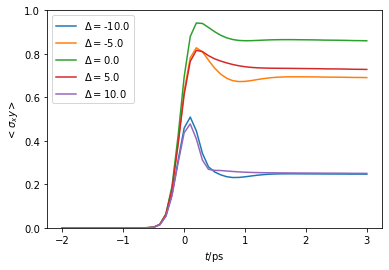

In [13]:
for t, s_xy, delta in zip(t_list, s_xy_list, deltas):
    plt.plot(t, s_xy, label=r"$\Delta = $"+f"{delta:0.1f}")
    plt.xlabel(r'$t/$ps')
    plt.ylabel(r'$<\sigma_xy>$')
plt.ylim((0.0,1.0))
plt.legend()